In [1]:
import pickle
import os
import sys
import shap
from decouple import config
sys.path.append(config('PYTHONPATH'))
from apps.income_prediction.app import App

with open(os.path.join(config('PYTHONPATH'), 'cache/model.sav'), 'rb') as f:
    model = pickle.load(f)

In [2]:
app = App()
app.load_data()
df = app.concatenate()
df = app.generate_growth(df, save=False)
df = app.bin_income_growth(df=df, target_column_name='target_income_growth')
df_train, df_holdout = app.withdraw_holdout(df)
X, y = app.pre_process(df_train)

[INFO App] 2020-04-16 06:24:38,849 load_data() - Loading data from /Users/vitaijdodonov/PycharmProjects/vhinny/vhinny-research/apps/income_prediction/data/master.csv
[INFO App] 2020-04-16 06:24:39,025 load_data() - Data has been loaded: (4384, 105)
[INFO App] 2020-04-16 06:24:39,060 concatenate() - Removing duplicates, row counts: 4384 -> 4372
[INFO App] 2020-04-16 06:24:39,061 concatenate() - Shape before join: (4372, 106)
[INFO App] 2020-04-16 06:24:39,140 concatenate() - Shape after join: (4372, 312)
[INFO App] 2020-04-16 06:24:39,216 generate_growth() - Shape after removing NULLs: 4372 -> 3655
[INFO App] 2020-04-16 06:24:39,218 bin_income_growth() - Binning the targets
[INFO App] 2020-04-16 06:24:39,243 withdraw_holdout() - Extracting holdout
[INFO App] 2020-04-16 06:24:39,343 withdraw_holdout() - Training / Holdout: 2678 / 977


In [3]:
X.head()

earnings_per_share_diluted_n-1  cf_cash_at_period_end_n-1  return_on_capital_n-1  return_on_tangible_assets_n-1  operating_margin_n-1  free_cash_flow_to_earnings_n-1  dividends_to_earnings_n-1  eps_growth_n-1
company_id fiscal_year                                                                                                                                                                                                                  
12981      2017                               1.404255               2.289000e+09               0.075122                       0.095042              0.082784                        2.231602                   0.324675        1.173131
           2016                               1.197015               2.003000e+09               0.068841                       0.085904              0.072661                        2.221945                   0.331671        0.802760
           2015                               1.491124               3.028000e+09               0.072341                       0.065805              0.065604                        1.867063                   0.349206        0.710550
           2014                               2.098551               2.675000e+09               0.090636                       0.107690              0.077217                        1.933702                   0.215470        0.642488
           2013                               3.266289               2.351000e+09               0.158010                       0.179455              0.089398                        3.122290                   0.090199        0.000000

In [4]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

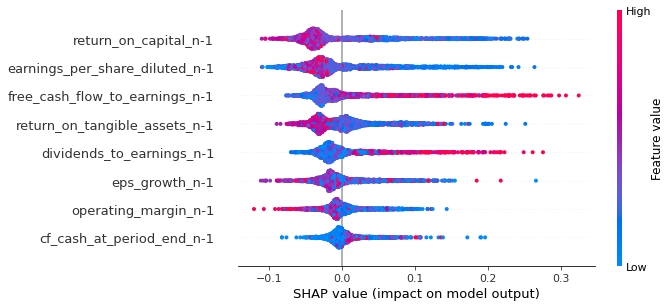

In [5]:
shap.summary_plot(shap_values[1], X)

In [6]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [7]:
i = 1072
p = shap.force_plot(explainer.expected_value[1], shap_values[1][i], X.iloc[[i]])
display(p)

In [10]:
X.reset_index().iloc[[i]]
X.reset_index()
X.describe()

,earnings_per_share_diluted_n-1,cf_cash_at_period_end_n-1,return_on_capital_n-1,return_on_tangible_assets_n-1,operating_margin_n-1,free_cash_flow_to_earnings_n-1,dividends_to_earnings_n-1,eps_growth_n-1
count,2678.000000,2.678000e+03,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000
mean,17.745004,2.675532e+09,0.140033,0.073231,-0.128605,3.468111,0.385168,3.153619
std,292.776434,8.526026e+09,1.245166,0.355217,12.650254,29.566365,2.353537,48.165593
min,-3565.449921,2.100000e+04,-34.327148,-15.721816,-651.923077,-598.386213,-35.431373,-527.334052
25%,1.386361,2.267330e+08,0.061885,0.024061,0.047157,1.520790,0.013163,0.000000
50%,2.616515,7.344430e+08,0.109310,0.072178,0.133046,2.395658,0.266806,0.967998
75%,4.508939,2.154406e+09,0.186303,0.138147,0.216191,4.474701,0.501584,1.173692
max,7385.044237,1.593530e+11,25.325000,0.808568,1.000000,590.247116,75.771084,1155.830421


In [42]:
X_ = X.copy()
X_['proba'] = model.predict_proba(X)[:, 1]
X_['true'] = y[5]
X_.reset_index(inplace=True)
X_[X_['true'] == 0].sort_values(by=['proba'], ascending=True)

def get_true_best(X_, limit=3):
    return X_.reset_index()[X_['true'] == 1].sort_values(by=['proba'], ascending=False).iloc[:limit]
    
def get_true_worst(X_, limit=3):
    return X_.reset_index()[X_['true'] == 1].sort_values(by=['proba'], ascending=True).iloc[:limit]
    
def get_false_best(X_, limit=3):
    return X_.reset_index()[X_['true'] == 0].sort_values(by=['proba'], ascending=True).iloc[:limit]
    
def get_false_worst(X_, limit=3):
    return X_.reset_index()[X_['true'] == 0].sort_values(by=['proba'], ascending=False).iloc[:limit]

X_temp = get_false_best(X_, 5)
display(X_temp)
for i in range(len(X_temp)):
    idx = X_temp.iloc[i]['index']
    p = shap.force_plot(explainer.expected_value[1], shap_values[1][int(idx)], X.iloc[[idx]])
    company_id = list(X.iloc[[idx]].index[0])[0]
    year = list(X.iloc[[idx]].index[0])[1]
    print(app.df[app.df['company_id'] == company_id].ticker.iloc[0], year)
    display(p)

,index,company_id,fiscal_year,earnings_per_share_diluted_n-1,cf_cash_at_period_end_n-1,return_on_capital_n-1,return_on_tangible_assets_n-1,operating_margin_n-1,free_cash_flow_to_earnings_n-1,dividends_to_earnings_n-1,eps_growth_n-1,proba,true
1337,1337,22525,2012,2.418809,1.802340e+08,0.255471,0.195621,0.369923,1.413480,0.000000,0.000000,0.0,0
1195,1195,1371,2015,3.755230,1.929000e+09,0.430043,0.137271,0.116302,1.696379,0.416527,1.251191,0.0,0
1198,1198,8067,2017,4.814359,2.258000e+08,0.089069,0.151949,0.084502,1.799080,0.000000,0.856189,0.0,0
1209,1209,1770,2016,3.917122,6.653300e+07,0.108047,0.122199,0.093999,1.839444,0.333614,2.749277,0.0,0
1212,1212,1770,2013,8.376848,1.757699e+09,0.216468,0.216148,0.143554,1.374380,0.381019,1.303875,0.0,0


IPGP 2012


HD 2015


HELE 2017


HFC 2016


HFC 2013


In [33]:
X_tb = get_true_best(X_, 30)
X_tw = get_false_best(X_, 30)
for column in X_tb:
    print(f'{column} \nTrue Best:  {(X_tb[column].mean()):.3f} ({(X_tb[column].std()):.3f}) \nTrue Worst: {(X_tw[column].mean()):.3f} ({(X_tw[column].std()):.3f})\n')

index 
True Best:  1577.567 (656.837) 
True Worst: 1199.433 (81.015)

company_id 
True Best:  11641.167 (9521.147) 
True Worst: 4004.200 (7072.579)

fiscal_year 
True Best:  2014.433 (1.654) 
True Worst: 2014.700 (1.822)

earnings_per_share_diluted_n-1 
True Best:  0.371 (0.379) 
True Worst: 4.598 (1.871)

cf_cash_at_period_end_n-1 
True Best:  2330363966.667 (4583054463.534) 
True Worst: 1718660566.667 (2257700114.998)

return_on_capital_n-1 
True Best:  0.013 (0.010) 
True Worst: 0.257 (0.197)

return_on_tangible_assets_n-1 
True Best:  0.010 (0.010) 
True Worst: 0.159 (0.066)

operating_margin_n-1 
True Best:  0.047 (0.108) 
True Worst: 0.143 (0.070)

free_cash_flow_to_earnings_n-1 
True Best:  107.319 (154.541) 
True Worst: 1.803 (0.474)

dividends_to_earnings_n-1 
True Best:  6.507 (16.673) 
True Worst: 0.251 (0.178)

eps_growth_n-1 
True Best:  0.185 (0.222) 
True Worst: 0.832 (1.577)

proba 
True Best:  0.929 (0.023) 
True Worst: 0.000 (0.000)

true 
True Best:  1.000 (0.000) 
T

In [30]:
# app.df
app.df[(app.df['company_id'] == 10283)].T

,1588,1589,1590,1591,1592,1593,1594,1595,1596
price,51.36,38.5923,30.7203,28.0232,28.6344,30.2724,24.2373,29.5206,31.117
date,2020-02-10,2019-02-19,2018-02-20,2017-02-21,2016-02-16,2015-02-17,2014-02-27,2013-02-25,2012-02-28
company_id,10283,10283,10283,10283,10283,10283,10283,10283,10283
ticker,FE,FE,FE,FE,FE,FE,FE,FE,FE
sector,Utilities,Utilities,Utilities,Utilities,Utilities,Utilities,Utilities,Utilities,Utilities
industry,Electric Utilities,Electric Utilities,Electric Utilities,Electric Utilities,Electric Utilities,Electric Utilities,Electric Utilities,Electric Utilities,Electric Utilities
reported_as_of,2019-12-31,2018-12-31,2017-12-31,2016-12-31,2015-12-31,2014-12-31,2013-12-31,2012-12-31,2011-12-31
filing_date,2020-02-10,2019-02-19,2018-02-20,2017-02-21,2016-02-16,2015-02-17,2014-02-27,2013-02-25,2012-02-28
is_template_id,1,1,1,1,1,1,1,1,1
bs_template_id,2,2,2,2,2,2,2,2,2
